# t-SNE

> t-distributed Stochastic Neighbor Embedding

- t-SNE: method to visualize high-dimensional data
- not *really* for dimensionality reduction:
    - non-deterministic projection into lower-dimensional space
    - however, great for visualization
- core idea: points that are neighbors in the *high-dimensional space* should still be neighbors in the *low-dimensional space*

https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf

In [1]:
import numpy as np

from sklearn.datasets import make_classification

In [2]:
X, y = make_classification(
    n_samples=1000,
    n_features=50,
    n_classes=2,
    n_informative=20,
    random_state=19
)

In [3]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(X, columns=[f"x_{i}" for i in range(X.shape[1])])
df["label"] = y
df.head()

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_41,x_42,x_43,x_44,x_45,x_46,x_47,x_48,x_49,label
0,0.106080,1.267071,-1.015977,0.213656,-0.889371,-0.911165,0.561162,-0.490518,-0.508581,-0.846340,...,1.316988,-2.588129,-0.381327,-0.179425,-0.282339,-0.251716,0.055685,0.790681,1.425536,0
1,1.863468,-2.391743,-0.459164,-0.619387,1.629182,-3.714418,-1.077220,-0.295575,2.592400,-3.259980,...,1.460523,2.948759,-0.531904,0.984301,0.665220,1.797137,-1.107526,-0.134940,3.627697,0
2,1.589967,-7.031950,-1.483571,-0.480922,-0.771485,-0.783863,-3.075218,-2.857635,-0.845585,3.687963,...,-0.026567,-2.308105,4.278797,0.576298,0.757222,-4.846073,0.149495,-1.741762,0.453306,1
3,0.826715,-1.640972,-1.573186,0.701939,0.247895,1.759066,-0.748541,-0.666828,1.966541,-4.219757,...,-1.625575,0.502905,0.113277,1.622616,1.045146,-0.739524,-1.060456,0.223586,-0.037295,0
4,-1.738905,-3.049806,0.286051,1.946423,0.162981,2.070677,-2.079269,0.826102,0.637575,-1.535638,...,0.493806,1.666271,2.533356,-1.711921,-0.900990,0.798268,-0.414979,-0.425339,-1.245540,0


<Axes: xlabel='x_0', ylabel='x_2'>

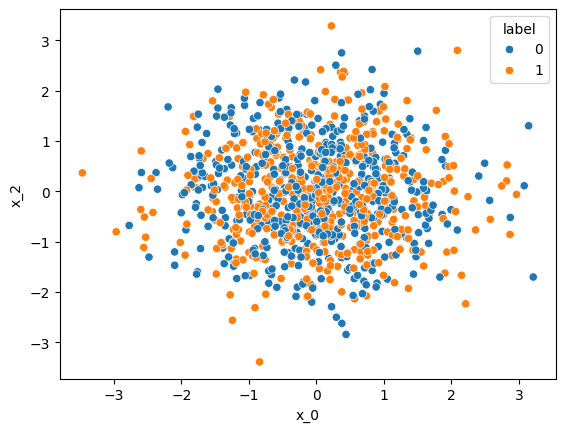

In [4]:
sns.scatterplot(
    df,
    x="x_0",
    y="x_2",
    hue="label"
)

<Axes: xlabel='label', ylabel='x_1'>

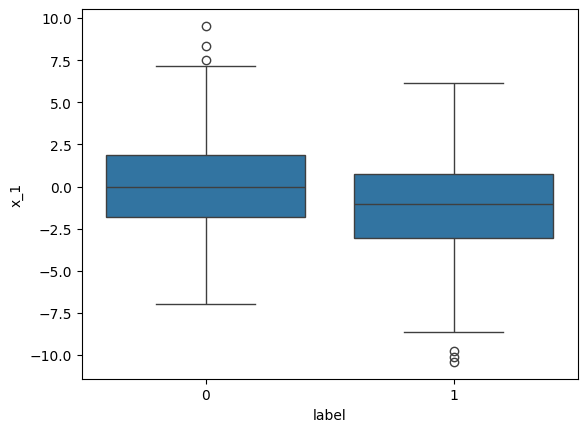

In [5]:
sns.boxplot(df, y="x_1", x="label")

In [6]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=19)

X_tsne = tsne.fit_transform(X)
X_tsne.shape

(1000, 2)

<Axes: xlabel='tsne_1', ylabel='tsne_2'>

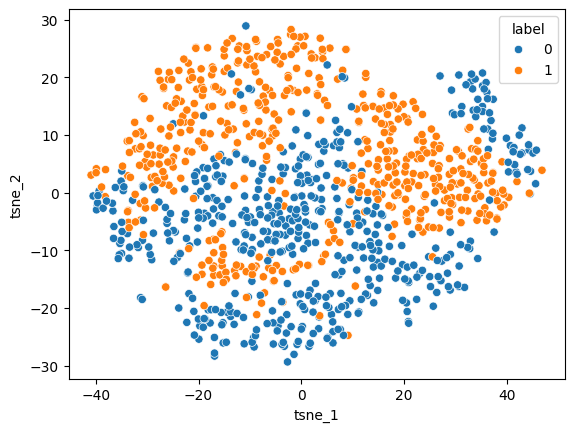

In [7]:
tsne_df = pd.DataFrame(X_tsne, columns=["tsne_1", "tsne_2"])
tsne_df["label"] = y

sns.scatterplot(tsne_df, x="tsne_1", y="tsne_2", hue="label")

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

X_pca = pca.fit_transform(X)
X_pca.shape

(1000, 2)

<Axes: xlabel='pca_1', ylabel='pca_2'>

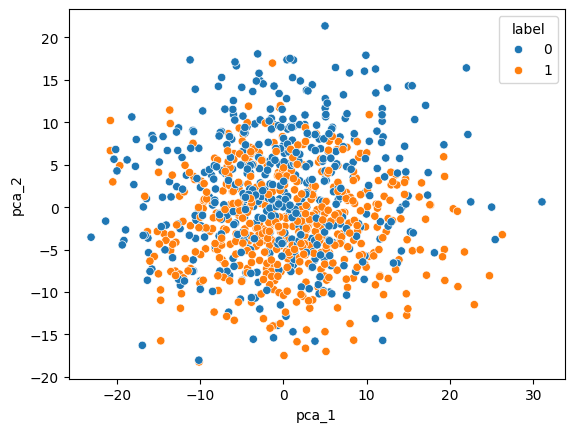

In [9]:
pca_df = pd.DataFrame(X_pca, columns=["pca_1", "pca_2"])
pca_df["label"] = y

sns.scatterplot(pca_df, x="pca_1", y="pca_2", hue="label")

## But how does it work?

In [20]:
def dist_mat(points_1, points_2):
    # points_1.shape (m, d) -> (m, 1, d)
    # points_2.shape (n, d)
    # distances.shape (m, n, d)
    # difference (m, 1, d) - (n, d)
    # broadcasted to (m, n, d)

    differences = points_1[:, np.newaxis, :] - points_2
    
    # could also use numpy.linalg.norm
    # from numpy.linalg import norm
    # distances = norm(differences, axis=2)

    # or we just implement the norm manually
    distances = np.sqrt(
        np.sum(differences * differences, axis=2)
    )

    return distances

In [21]:
d = dist_mat(X, X)

In [ ]:
def probs_q_sym(distances):
    """Symmetrical probabilities Q in the lower dimensional space"""
    exp_dists = np.exp(-1 * distances)
    diag = np.diag_indices_from(exp_dists)

    # a little trick: we set diagonal elements to 0
    # since we want to exclude points where k==l
    exp_dists[diag] = 0
    q = exp_dists / exp_dists.sum()
    return q

In [ ]:
def probs_p_cond(distances):
    """
    Conditional probabilities P in the higher dimensional space

    Returns:
        M: numpy matrix, where m_{ij} is the conditional probability p_{j|i}
        Where i is the row index and j is the column index.
        I.e., each row is a conditional probability distribution, that adds up to 1.
    """
    exp_dists = np.exp(-distances)
    diag = np.diag_indices_from(exp_dists)

    # a little trick: we set diagonal elements to 0
    # since we want to exclude points where k==l
    exp_dists[diag] = 0
    # use keepdims=True to divide row-wise, instead of column-wise
    q = exp_dists / exp_dists.sum(axis=1, keepdims=True)
    return q

In [35]:
def symmetrize_probs(probs):
    n, m = probs.shape
    if n != m:
        raise ValueError("probability matrix must be symmetric!")
    # divide by 2 n, to make sure that probability mass over all points adds up to 1
    probs =  (probs + probs.T) / (2*n)
    return probs


In [37]:
symmetrize_probs(probs_p_cond(d)).sum()

np.float64(0.9999999999999999)

In [62]:
probs(X).sum()

np.float64(1.0)

In [63]:
def gradient(p, q, y):
    return 4 * (p - q).sum()